In [1]:
import numpy as np
import scipy.linalg
import mujoco
from typing import Callable, Optional, Union, List
import mediapy as media
import matplotlib.pyplot as plt

""

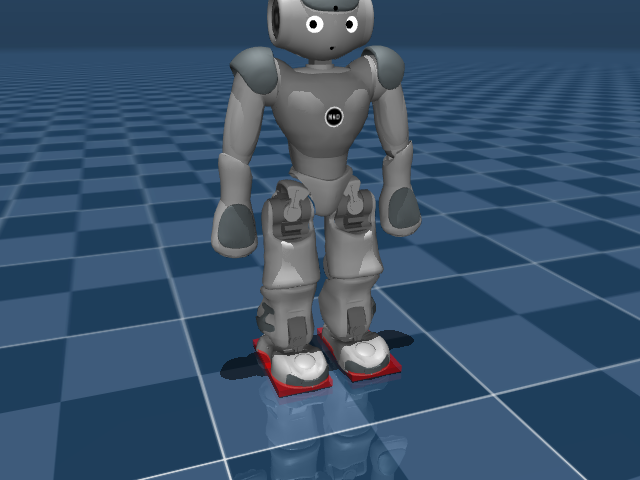

In [2]:
with open('scene.xml', 'r') as f:
  xml = f.read()
  
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, width=640, height=480)

mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [3]:
from nao import Nao

nao = Nao(model, data)

print(nao.accelerometer)
print(nao.right_fsr_values)

[-4.00142529e-04 -2.66562393e-05  3.85045246e-02]
[[0.]
 [0.]
 [0.]
 [0.]]


In [4]:
np.set_printoptions(formatter={"float": "{: 0.5f}".format})
from enum import Enum

def get_joint_idx(data: mujoco.MjData, name: str) -> int:
    return data.jnt(name).id - 1

fsr_positions = {
    "RFoot": {
        "fl": {"x": 0.07025, "y": 0.0299},
        "fr": {"x": 0.07025, "y": -0.0231},
        "bl": {"x": -0.03025, "y": 0.0299},
        "br": {"x": -0.02965, "y": -0.0191},
    },
    "LFoot": {
        "fl": {"x": 0.07025, "y": 0.0231},
        "fr": {"x": 0.07025, "y": -0.0299},
        "bl": {"x": -0.03025, "y": 0.0191},
        "br": {"x": -0.02965, "y": -0.0299},
    },
}


class Foot(Enum):
    LEFT = 1
    RIGHT = 2

    def __str__(self):
        if self == Foot.LEFT:
            return "LFoot"
        else:
            return "RFoot"


def estimate_foot_zmp(
    data: mujoco.MjData, fsr_data: np.ndarray, foot: Foot
) -> np.ndarray:
    foot_id: str = str(foot)
    foot = data.body(foot_id).xpos
    fl_x = foot[0] + fsr_positions[foot_id]["fl"]["x"]
    fr_x = foot[0] + fsr_positions[foot_id]["fr"]["x"]
    bl_x = foot[0] + fsr_positions[foot_id]["bl"]["x"]
    br_x = foot[0] + fsr_positions[foot_id]["br"]["x"]

    fl_y = foot[1] + fsr_positions[foot_id]["fl"]["y"]
    fr_y = foot[1] + fsr_positions[foot_id]["fr"]["y"]
    bl_y = foot[1] + fsr_positions[foot_id]["bl"]["y"]
    br_y = foot[1] + fsr_positions[foot_id]["br"]["y"]

    zmp_x = (
        fl_x * fsr_data[0]
        + fr_x * fsr_data[1]
        + bl_x * fsr_data[2]
        + br_x * fsr_data[3]
    ) / fsr_data.sum()
    zmp_y = (
        fl_y * fsr_data[0]
        + fr_y * fsr_data[1]
        + bl_y * fsr_data[2]
        + br_y * fsr_data[3]
    ) / fsr_data.sum()

    return np.array([zmp_x[0], zmp_y[0], 0.0])


def estimate_zmp(data: mujoco.MjData) -> np.ndarray:
    r_bl = data.sensor("RFootFSRBackLeft").data.copy()
    r_br = data.sensor("RFootFSRBackRight").data.copy()
    r_fl = data.sensor("RFootFSRFrontLeft").data.copy()
    r_fr = data.sensor("RFootFSRFrontRight").data.copy()
    right_fsr = np.array([r_bl, r_br, r_fl, r_fr])

    l_bl = data.sensor("LFootFSRBackLeft").data.copy()
    l_br = data.sensor("LFootFSRBackRight").data.copy()
    l_fl = data.sensor("LFootFSRFrontLeft").data.copy()
    l_fr = data.sensor("LFootFSRFrontRight").data.copy()
    left_fsr = np.array([l_bl, l_br, l_fl, l_fr])

    left_on_ground = np.sum(left_fsr) > 0.1
    right_on_ground = np.sum(right_fsr) > 0.1

    # Left Foot ZMP
    lf_zmp = np.zeros(3)
    if left_on_ground:
        lf_zmp = estimate_foot_zmp(data, left_fsr, Foot.LEFT)

    # Right Foot ZMP
    rf_zmp = np.zeros(3)
    if right_on_ground:
        rf_zmp = estimate_foot_zmp(data, right_fsr, Foot.RIGHT)

    if left_on_ground and right_on_ground:
        return (lf_zmp + rf_zmp) / 2
    elif left_on_ground:
        return lf_zmp
    elif right_on_ground:
        return rf_zmp
    else:
        return np.zeros(3)

In [5]:
# DURATION = 3  # seconds
# FRAMERATE = 60  # Hz

# # Make a new camera, move it to a closer distance.
# camera = mujoco.MjvCamera()
# mujoco.mjv_defaultFreeCamera(model, camera)
# camera.distance = 2

# mujoco.mj_resetDataKeyframe(model, data, 0)
# mujoco.mj_forward(model, data)

# print(data.qpos)

# print(data.actuator(21))
    
# frames = []
# times = []
# sensordata = []
# zmpdata = []

# q_initial = {
#     "RShoulderPitch": -90,
#     "LShoulderPitch": -90,
#     "HeadYaw": -90,
# }

# for joint, q in q_initial.items():
#     joint_idx = data.joint(joint).id - 1
#     data.qpos[joint_idx] = q * np.pi / 180

# q_des = {
#     "RShoulderPitch": -30,
# }

# while data.time < DURATION:
#     # # Set the desired joint positions.
#     # for joint, q in q_des.items():
#     #     joint_idx = data.actuator(joint).id
#     #     q_cur = data.qpos[joint_idx]
#     #     print(q_cur)
#     #     q = q * np.pi / 180
#     #     data.ctrl[joint_idx] = q_cur + data.time * (q - q_cur) / DURATION

#     # Step the simulation.
#     mujoco.mj_step(model, data)
#     # mujoco.mj_forward(model, data)

#     # Render and save frames.
#     if len(frames) < data.time * FRAMERATE:
#         # Set the lookat point to the humanoid's center of mass.
#         camera.lookat = data.body("Nao").subtree_com
#         renderer.update_scene(data, camera)
#         pixels = renderer.render()
#         frames.append(pixels)
#         times.append(data.time)
#         zmp = estimate_zmp(data)
#         zmpdata.append(zmp)

# media.show_video(frames, fps=FRAMERATE)

# ax = plt.gca()
# ax.plot(
#     np.asarray(times), np.asarray(zmpdata), label=[f"axis {v}" for v in ["x", "y", "z"]]
# )
# ax.set_title("ZMP")
# ax.legend(frameon=True, loc="lower right")
# plt.tight_layout()